In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
from functools import partial

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
data_path = os.path.join(base_path, "vc_runs")
fig_path = os.path.join(base_path, "multiplex_rho_figs")
fig_subdir = None

fig_subdir, exp_names = ("test", {
    "ctrl": "poissarma_etau3_x0p6w_itau6_x0p8w_ar_0p9_-0p1_rho95_6n_5tr_rho_range",
    "older": "poissarma_etau3_x0p6w_itau6_x0p8w_ar_0p9_-0p1_6n_5tr_rho_range",
})


fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
exp_hdfs = {k: h5.File(os.path.join(data_path, n) + ".h5", "r") for k, n in exp_names.items()}
d = {k: Workspace(hdf, read_only=True) for k, hdf in exp_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

exps = list(d.keys())
ctrl_lbl = exps[0]
expr_lbl = exps[-1]
# ctrl_lbl = "ctrl"
# expr_lbl = "plex3"
ctrl = d[ctrl_lbl]
expr = d[expr_lbl]

rhos = list(ctrl.keys())
idxs = list(ctrl[rhos[0]].keys())
exp_keys = list(ctrl[rhos[0]][idxs[0]].keys())
transmitters = list(ctrl[rhos[0]][idxs[0]]["soma"].keys())
n_trials, n_dirs, n_steps = ctrl[rhos[0]][idxs[0]]["soma"]["E"].shape
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("rec keys:", transmitters)
print("rec shape:", (n_trials, n_dirs, n_steps))

==keys==
rhos: [0.0, 0.4, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 1.0]
idxs: [0, 1, 2, 3, 4, 5]
exp keys: ['params', 'sac_net', 'soma', 'syn_locs']
rec keys: ['ACH', 'AMPA', 'E', 'GABA']
rec shape: (5, 8, 7501)


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
params = d[ctrl_lbl][1.0][0]["params"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]

dir_labels = ctrl[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
sac_thetas = {exp: ana.get_sac_thetas(wrk) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 

In [7]:
vc_recs = {}
for exp in exps:
    vc_recs[exp] = {}
    for rho in rhos:
        vc_recs[exp][rho] = {}
        for net in idxs:
            vc_recs[exp][rho][net] = {}
            for trans in transmitters:
                rec = d[exp][rho][net]["soma"][trans]
                base_fun = np.min if trans == "GABA" else np.max
                vc_recs[exp][rho][net][trans] = (
                    rec - base_fun(rec, axis=-1, keepdims=True))

vc_trial_avgs = {
    exp: {
        rho: {
            n: {trans: np.mean(rec, axis=0) for trans, rec in net.items()}
            for n, net in nets.items()
        }
        for rho, nets in recs.items()      
    }
    for exp, recs in vc_recs.items()
}
    
vc_net_avgs = {
    exp: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in transmitters
        }
        for rho, nets in avgs.items()
    }
    for exp, avgs in vc_trial_avgs.items()
}

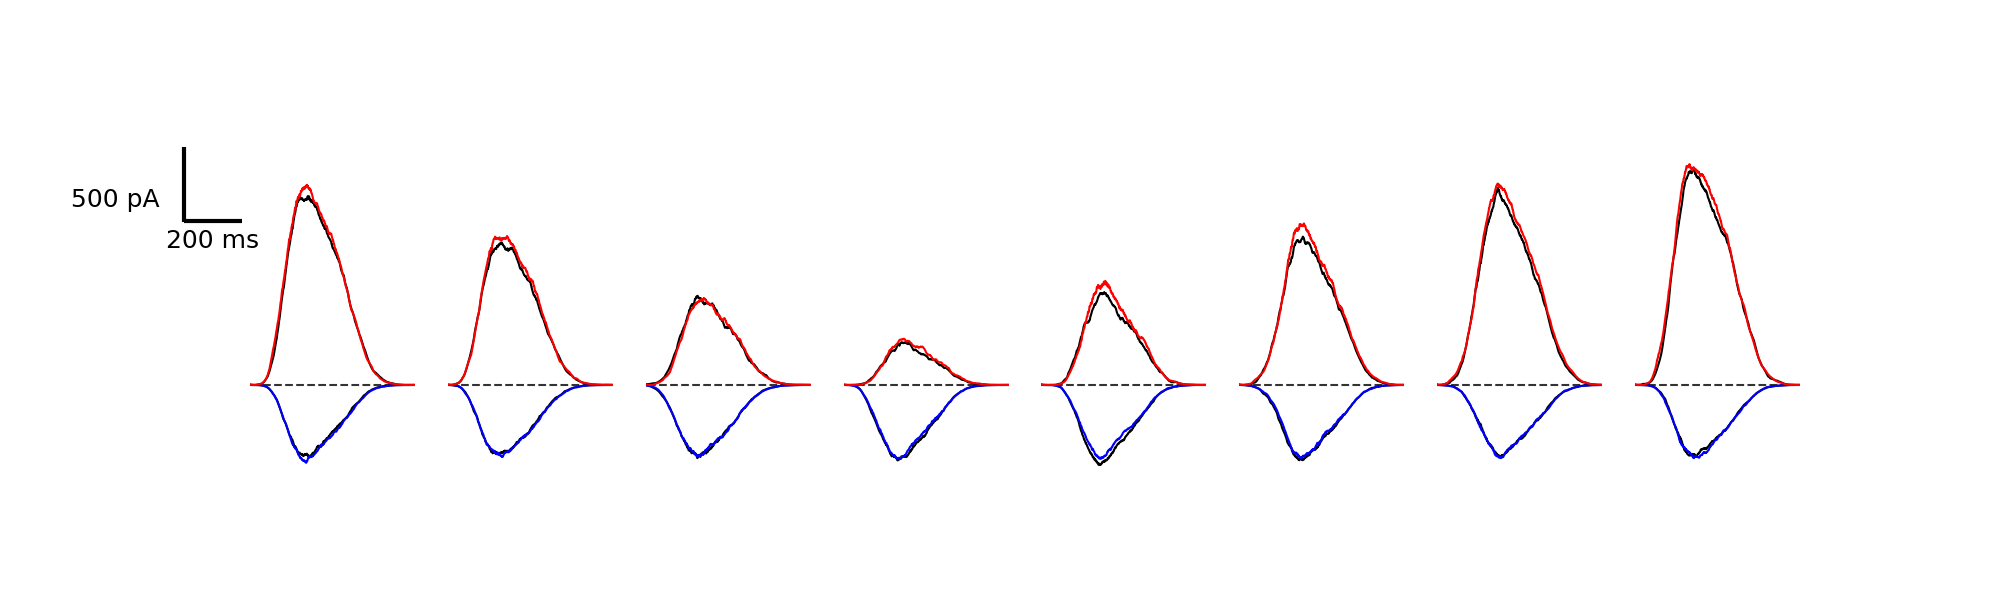

In [8]:
row_conds = [
    {"exp": ctrl_lbl, "rho":1.0},
    # {"exp": expr_lbr, "rho":1.0},
    {"exp": ctrl_lbl, "rho":0.0},
]

colours = ([("black", "black"), ("blue", "red")]
           if len(row_conds) > 1
           else  [("blue", "red")])

net = 0
trial = 0
xmin = 30
xmax = 600
# vc_mode = "trial"  # net_avg, trial_avg, or trial (default)
# vc_mode = "trial_avg"
vc_mode = "net_avg"

if vc_mode == "net_avg":
    get_vc = lambda exp, rho, trans: vc_net_avgs[exp][rho][trans]
elif vc_mode == "trial_avg":
    get_vc = lambda exp, rho, trans: vc_trial_avgs[exp][rho][net][trans]
else:
    get_vc = lambda exp, rho, trans: d[exp][rho][net]["soma"][trans][trial]

trial_vc_fig, trial_vc_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 6))

for i, ax in enumerate(trial_vc_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    for j, row in enumerate(row_conds):
        e_col, i_col = colours[j]
        ax.plot(xaxis, get_vc(row["exp"], row["rho"], "E")[i], c=e_col)
        ax.plot(xaxis, get_vc(row["exp"], row["rho"], "GABA")[i], c=i_col)
    ax.patch.set_alpha(0)

sizex = 200
sizey = 0.5
vc_sb = add_scalebar(
    trial_vc_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i pA" % (sizey * 1000),
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 400),
    textprops={"fontsize": 18},
)

clean_axes(trial_vc_ax, remove_spines=["left", "right", "top", "bottom"])
trial_vc_ax[0].set_ylim(-1, 2.1)
trial_vc_ax[0].set_xlim(xmin, xmax)

rho_tag = lambda r: "rho" +  ("%.2f" % r).replace(".", "p")
if len(row_conds) == 1:
    prefix = "vc_%s_%s" % (row_conds[0], rho_tag(row_conds[0]))
elif len(row_conds) == 2:
    k1, k2 = (cond["exp"] for cond in row_conds)
    prefix = "vc_%s_%s_%s_%s" % (k1, rho_tag(row_conds[0]["rho"]), k2, rho_tag(row_conds[0]["rho"]))
    
if vc_mode == "trial":
    name = "%s_net%i_trial%i" % (prefix, net, trial)
elif vc_mode == "trial_avg":
    name = "%s_net%i_avg" % (prefix, net)
elif vc_mode == "net_avg":
    name = "%s_all_net_avg" % prefix
for ext in [".png", ".svg"]:
    trial_vc_fig.savefig(os.path.join(fig_path, name) + ext, transparent=True)

In [9]:
upward_e_avgs = vc_net_avgs[ctrl_lbl][1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [ 98.1  82.1  67.2  87.3 103.  100.3 101.6 106.1]
alignment_shifts (ms): [ 8.  24.  38.9 18.8  3.1  5.8  4.5  0. ]


Text(0.5, 0, 'Time (ms)')

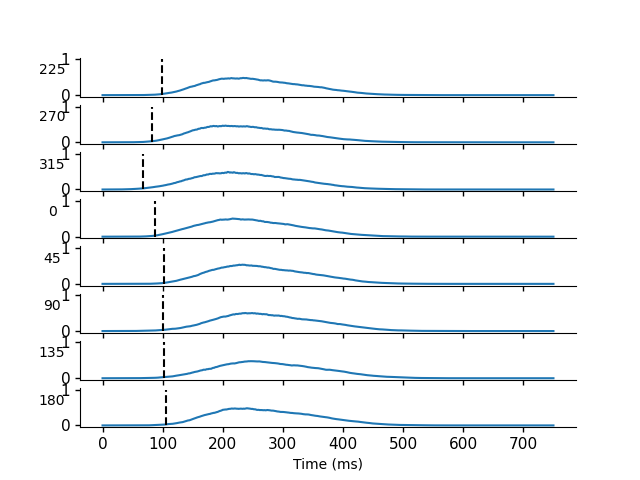

In [10]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (ms)")

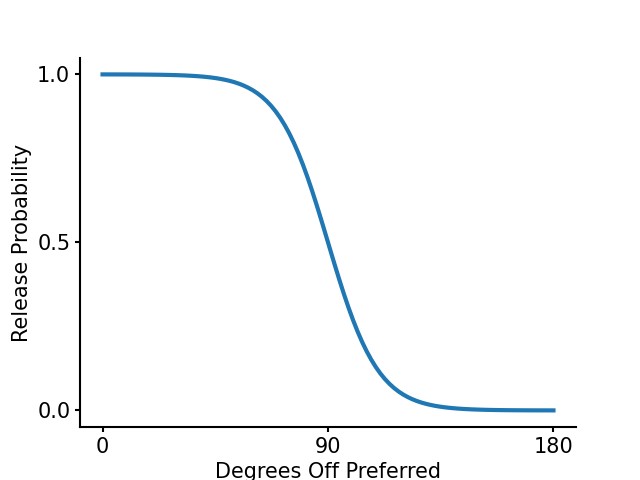

In [11]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

# null_pr = 0.05
# pref_pr = 0.95
null_pr = 0.0
pref_pr = 1.0

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr))
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, slope=null_pr))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
# sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
# sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5)
# sigmoid_fig.legend()
sigmoid_fig.savefig(os.path.join(fig_path, "prob_sigmoid.svg"), bbox_inches="tight")

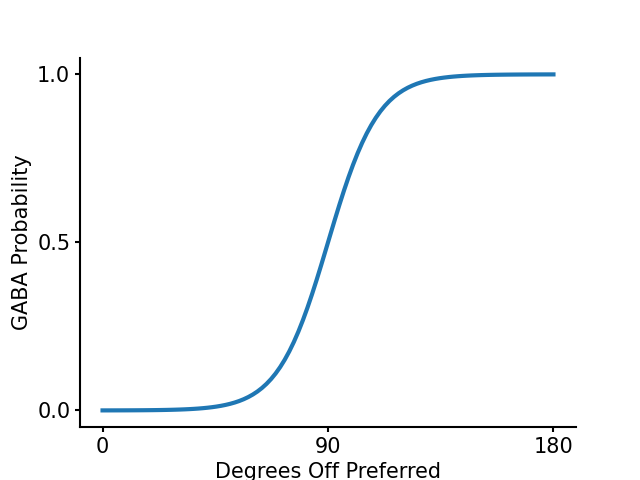

In [12]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(180 - dir_range, prob_p1, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

In [13]:
res_e = "ACH"
res_i = "GABA"
start_t = 0  # ms
start_idx = nearest_index(xaxis, start_t)
res_xaxis = xaxis[start_idx:]
residuals = {
    exp: {
        rho: {
            net: {
                k: vc_recs[exp][rho][net][k][:, :, start_idx:] - vc_trial_avgs[exp][rho][net][k][:, start_idx:]
                for k in [res_e, res_i] 
            }
            for net in idxs
        }
        for rho in rhos
    }
    for exp in exps
}

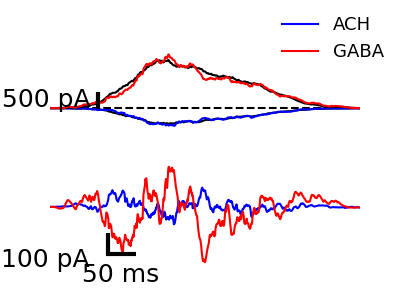

In [24]:
exp = ctrl_lbl
rho = 1.0
net = 0
trial = 0
angle = 180
normalize_resid = False
invert_i = False
scalebar_mode = True
dir_idx = np.argwhere(dir_labels == angle)[0][0]

residual_ex_fig, residual_ex_ax = plt.subplots(
    2,
    sharex=True,
    figsize=(4, 3),
)

residual_ex_ax[0].plot([np.min(xaxis), np.max(xaxis)], [0, 0], c="black", linestyle="--")
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[exp][rho][net][res_e][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[exp][rho][net][res_e][trial, dir_idx], c="blue", label=res_e)
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[exp][rho][net][res_i][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[exp][rho][net][res_i][trial, dir_idx], c="red", label=res_i)

ex_resid_e = residuals[exp][rho][net][res_e][trial, dir_idx]
ex_resid_i = residuals[exp][rho][net][res_i][trial, dir_idx]
ex_resid_i = -1 * ex_resid_i if invert_i else ex_resid_i
if normalize_resid:
    ex_resid_e = ex_resid_e / np.std(ex_resid_e)
    ex_resid_i = ex_resid_i / np.std(ex_resid_i)
residual_ex_ax[1].plot(res_xaxis, ex_resid_e, c="blue")
residual_ex_ax[1].plot(res_xaxis, ex_resid_i, c="red")

norm_prefix = "Normalized " if normalize_resid else ""
residual_ex_ax[0].set_ylim(-1, 2.2)
residual_ex_ax[-1].set_xlim(40, 550)
residual_ex_fig.legend(frameon=False, fontsize=13)

if scalebar_mode:
    vc_sb = add_scalebar(
        residual_ex_ax[0], 
        matchx=False, 
        matchy=False, 
        sizey=0.5, 
        labely="500 pA",
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(50, 200),
        textprops={"fontsize": 18},
    )
    res_sb = add_scalebar(
        residual_ex_ax[1], 
        matchx=False, 
        matchy=False, 
        sizex=50, 
        labelx="50 ms",
        sizey=0.1, 
        labely="100 pA",
        ysep=-5,
        sep=5,
        barwidth=3,
        loc="center",
        # bbox_to_anchor=(50, 70),
        bbox_to_anchor=(80, 40),
        textprops={"fontsize": 18},
    )
    clean_axes(residual_ex_ax, remove_spines=["left", "top", "right", "bottom"])
    # residual_ex_fig.set_layout_engine("compressed")
    # residual_ex_fig.tight_layout()
else:
    residual_ex_ax[0].set_ylabel("Current (nA)", fontsize=14)
    residual_ex_ax[1].set_ylabel(norm_prefix + "Residual (nA)", fontsize=14)
    residual_ex_ax[-1].set_xlabel("Time (ms)", fontsize=14)
    clean_axes(residual_ex_ax, ticksize=13, spine_width=1.5)

name = "residual_ex_%s_rho%s_net%i_d%i_tr%i%s%s%s" % (
    exp,
    str(rho).replace(".", "p"),
    net,
    angle,
    trial,
    "_norm" if normalize_resid else "",
    "_inv" if invert_i else "",
    "_scalebars" if scalebar_mode else "",
)
for ext in [".png", ".svg"]:
    residual_ex_fig.savefig(os.path.join(fig_path, name + ext), bbox_inches="tight")

In [15]:
shuffle_mode = False
shuffle_lbl = "_shuffled" if shuffle_mode else ""
shift_idxs = np.arange(n_trials) - 1
def norm_residual_xcorr(corr_mode, shuffle=False):
    return {
        exp: {
            rho: {
                i: map_axis(
                    lambda s: np.squeeze(norm_xcorr(s[0], s[1], mode=corr_mode)),
                    np.stack([net[res_e], net[res_i][shift_idxs] if shuffle else net[res_i]], axis=-2), 
                    axis=-2
                )
                for i, net in nets.items()
            }
            for rho, nets in resids.items()
        }
        for exp, resids in residuals.items()
   } 

residual_corr_valid = norm_residual_xcorr("valid", shuffle=shuffle_mode)
residual_corr_full = norm_residual_xcorr("full", shuffle=shuffle_mode)

In [16]:
def reduce_xcorr_trials(f, corrs):
    return {
        exp: {
            rho: {i: f(net) for i, net in nets.items()}
            for rho, nets in corrs[exp].items()
        }
        for exp in exps
    }
residual_corr_valid_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_valid)
residual_corr_full_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_full)
residual_corr_full_peak_trial_avg = reduce_xcorr_trials(partial(np.min, axis=-1), residual_corr_full_trial_avg)

def reduce_xcorr_nets(f, corrs):
    return {
        exp: {
            rho: f(np.stack([net for net in nets.values()], axis=0))
            for rho, nets in corrs[exp].items()
        }
        for exp in exps
    }
mean_ax0, std_ax0 = partial(np.mean, axis=0), partial(np.std, axis=0)
residual_corr_valid_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_peak_trial_avg)
residual_corr_valid_net_std = reduce_xcorr_nets(std_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_peak_trial_avg)

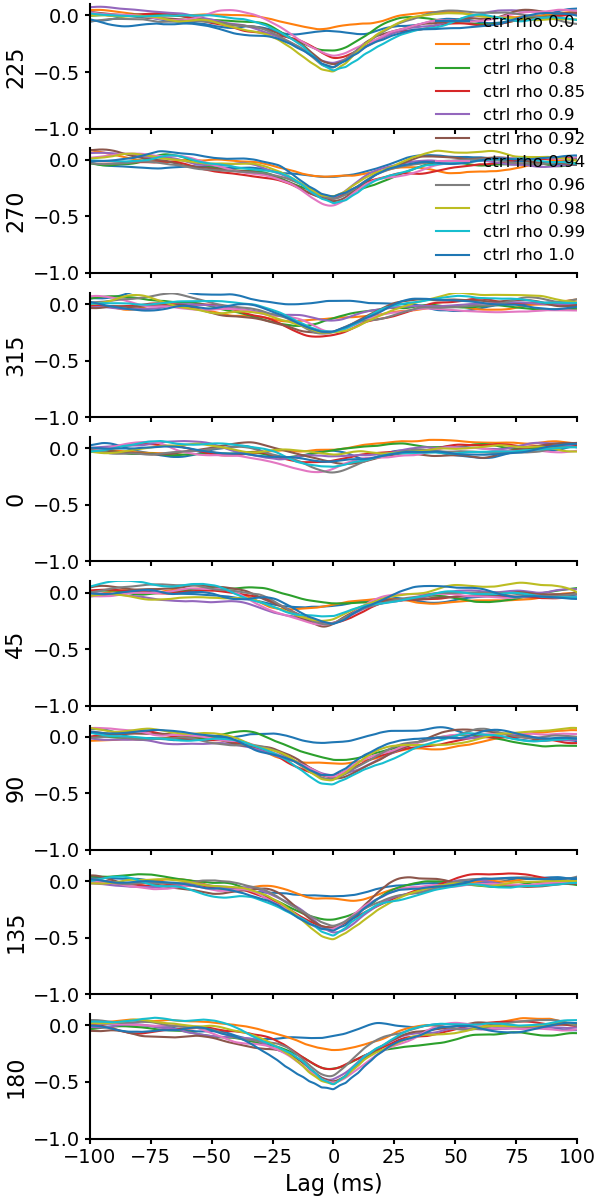

In [51]:
display_exps = exps
display_exps = [ctrl_lbl]
display_rhos = rhos
# display_rhos = [0.0, 0.4, 0.8, 1.0]

colours = ["C%i" % i for i in range(15)]
exp_styles = ["-", "--", "-.", ":"] 
exp_hatches = ["", "o", "*", "/"]
exp_hatches = ["" for _ in exp_styles]

full_xaxis = np.concatenate([np.flip(res_xaxis[1:] * -1), res_xaxis])
dir_residual_corr_fig, dir_residual_corr_ax = plt.subplots(len(dir_labels), sharex=True, sharey=True, figsize=(6, 12))
for i in range(len(dir_labels)):
    for j, exp in enumerate(display_exps):
        for rho, clr in zip(display_rhos, colours):
            lbl = ("%s rho %s" % (exp, str(rho))) if not i else None
            dir_residual_corr_ax[i].plot(
                full_xaxis,
                residual_corr_full_net_avg[exp][rho][i],
                c=clr,
                linestyle=exp_styles[j],
                label=lbl
            )
    dir_residual_corr_ax[i].set_ylabel(dir_labels[i], fontsize=16)

dir_residual_corr_ax[-1].set_xlim(-100, 100)
dir_residual_corr_ax[-1].set_ylim(-1, 0.1)
dir_residual_corr_ax[-1].set_xlabel("Lag (ms)", fontsize=16)
dir_residual_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dir_residual_corr_ax, ticksize=14, spine_width=1.5)
dir_residual_corr_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "directional_residual_xcorr_%s_%s%s" %(exps_lbl, rhos_lbl, ext)
    dir_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

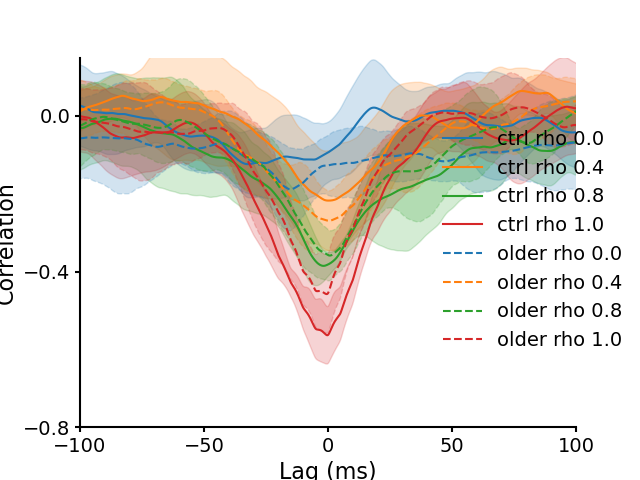

In [52]:
display_exps = exps
# display_exps = [ctrl_lbl]
display_rhos = rhos
display_rhos = [0.0, 0.4, 0.8, 1.0]

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}
rho_to_clr = {k: v for k, v in zip(display_rhos, colours)}

def plot_residual_corr_w_std(ax, exp, rho, dir_idx, color=None, style=None, hatch=None, alpha=0.2, label=None):
    ax.fill_between(
        full_xaxis, 
        residual_corr_full_net_avg[exp][rho][dir_idx] + residual_corr_full_net_std[exp][rho][dir_idx], 
        residual_corr_full_net_avg[exp][rho][dir_idx] - residual_corr_full_net_std[exp][rho][dir_idx], 
        alpha=alpha,
        hatch=hatch,
        **({"color": color} if color is not None else {}),
        **({"linestyle": style} if style is not None else {}),
    )
    ax.plot(
        full_xaxis, 
        residual_corr_full_net_avg[exp][rho][dir_idx],
        c=color,
        linestyle=style,
        label=label
    )
    
null_residual_corr_fig, null_residual_corr_ax = plt.subplots(1)
for exp in display_exps:
    for rho in display_rhos:
        lbl = "%s rho %s" % (exp, str(rho))
        plot_residual_corr_w_std(
            null_residual_corr_ax,
            exp,
            rho,
            null_idx,
            color=rho_to_clr[rho],
            style=exp_to_style[exp],
            hatch=exp_to_hatch[exp],
            label=lbl,
        )
    
null_residual_corr_ax.set_xlim(-100, 100)
null_residual_corr_ax.set_ylim(-0.8, 0.15)
null_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
null_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
null_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
null_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
null_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(null_residual_corr_ax, ticksize=14, spine_width=1.5)

exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "null_residual_xcorr_%s%s%s" % (exp, shuffle_lbl, ext) 
    null_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

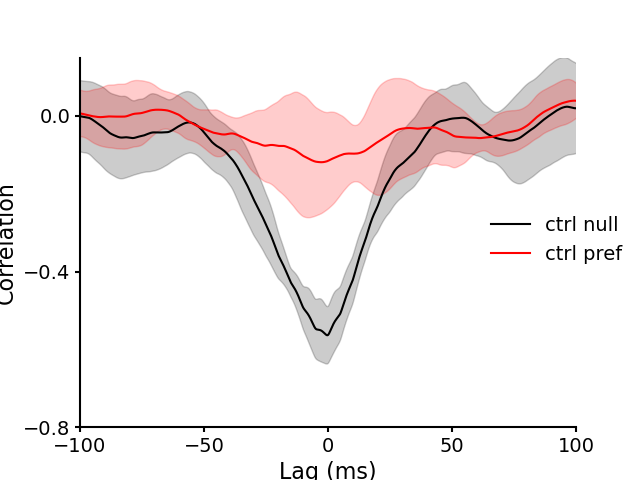

In [63]:
display_exps = exps
display_exps = [ctrl_lbl]
rho = 1
display_dirs = {
    "null": {"idx": null_idx, "color": "black"},
    "pref": {"idx": pref_idx, "color": "red"},
}

exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}

def plot_dirs_residual_corr(ax, exp, dirs, style=None, hatch=None, incl_lbl=True):
    for lbl, ps in dirs.items(): 
        plot_residual_corr_w_std(
            ax,
            exp,
            rho,
            ps["idx"],
            color=ps["color"],
            style=style,
            hatch=hatch,
            label="%s %s" % (exp, lbl) if incl_lbl else None,
        )
    
dirs_residual_corr_fig, dirs_residual_corr_ax = plt.subplots(1)
for exp in display_exps:
    plot_dirs_residual_corr(
        dirs_residual_corr_ax,
        exp,
        display_dirs,
        style=exp_to_style[exp],
        hatch=exp_to_hatch[exp],
    )
dirs_residual_corr_ax.set_xlim(-100, 100)
dirs_residual_corr_ax.set_ylim(-0.8, 0.15)
dirs_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
dirs_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
dirs_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
dirs_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
dirs_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(dirs_residual_corr_ax, ticksize=14, spine_width=1.5)

dirs_lbl = "_".join(reversed(display_dirs.keys()))
exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    name = "%s_residual_xcorr_%s_rho%s%s%s" % (dirs_lbl, exps_lbl, str(rho).replace(".", "p"), shuffle_lbl, ext)
    dirs_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

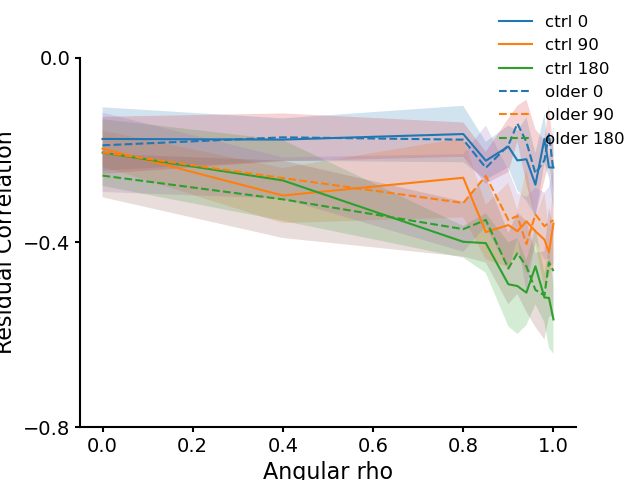

In [69]:
# TODO make this one like above (which eliminates need for separate pref-null version)

display_exps = exps
# display_exps = [ctrl_lbl]
show_stds = True
display_dirs = dir_labels
display_dirs = [0, 90, 180]
rho_vs_corr_fig, rho_vs_corr_ax = plt.subplots(1)

colours = ["C%i" % i for i in range(len(dir_labels))]
exp_to_style = {k: v for k, v in zip(display_exps, exp_styles)}
exp_to_hatch = {k: v for k, v in zip(display_exps, exp_hatches)}

for exp in display_exps:
    style = exp_to_style[exp]
    hatch = exp_to_hatch[exp]
    for angle, clr in zip(display_dirs, colours):
        i = np.argwhere(dir_labels == angle)[0][0]
        corrs = np.array([residual_corr_full_peak_net_avg[exp][r][i] for r in rhos])
        if show_stds:
            corr_stds = np.array([residual_corr_full_peak_net_std[exp][r][i] for r in rhos])
            rho_vs_corr_ax.fill_between(
                rhos, corrs + corr_stds, corrs - corr_stds, hatch=hatch, linestyle=style, alpha=0.2)
        lbl = "%s %i" % (exp, dir_labels[i])
        rho_vs_corr_ax.plot(rhos, corrs, c=clr, linestyle=style, label=lbl)

min_y = -0.8
rho_vs_corr_ax.set_ylim(min_y, 0)
rho_vs_corr_ax.set_yticks([min_y, min_y / 2, 0.])
rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(rho_vs_corr_ax, ticksize=14, spine_width=1.5)

dirs_lbl = "_".join(map(str, display_dirs))
exps_lbl = "_".join(display_exps)
for ext in [".png", ".svg"]:
    name = "rho_vs_residual_xcorr_%s_dirs_%s_%s%s" % (exps_lbl, dirs_lbl, shuffle_lbl, ext)
    rho_vs_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

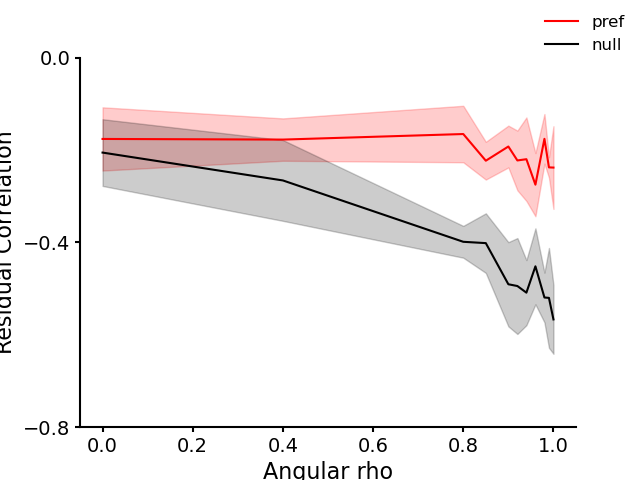

In [29]:
exp = ctrl_lbl
pref_corrs = np.array([residual_corr_full_peak_net_avg[exp][r][pref_idx] for r in rhos]) 
pref_corr_stds = np.array([residual_corr_full_peak_net_std[exp][r][pref_idx] for r in rhos])
null_corrs = np.array([residual_corr_full_peak_net_avg[exp][r][null_idx] for r in rhos]) 
null_corr_stds = np.array([residual_corr_full_peak_net_std[exp][r][null_idx] for r in rhos])

def plot_pn_rho_vs_corr(ax):
    ax.fill_between(
        rhos, 
        pref_corrs + pref_corr_stds, 
        pref_corrs - pref_corr_stds, 
        color="red",
        alpha=0.2,
    )
    ax.plot(rhos, pref_corrs, c="red", label="pref")
    ax.fill_between(
        rhos, 
        null_corrs + null_corr_stds, 
        null_corrs - null_corr_stds, 
        color="black",
        alpha=0.2,
    )
    ax.plot(rhos, null_corrs, c="black", label="null")

pn_rho_vs_corr_fig, pn_rho_vs_corr_ax = plt.subplots(1)
plot_pn_rho_vs_corr(pn_rho_vs_corr_ax)

min_y = -0.8
pn_rho_vs_corr_ax.set_ylim(min_y, 0)
pn_rho_vs_corr_ax.set_yticks([min_y, min_y / 2, 0.])
pn_rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
pn_rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
pn_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(pn_rho_vs_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    name = os.path.join(fig_path, "pref_null_rho_vs_residual_xcorr_%s%s%s" % (exp, shuffle_lbl, ext))
    pn_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

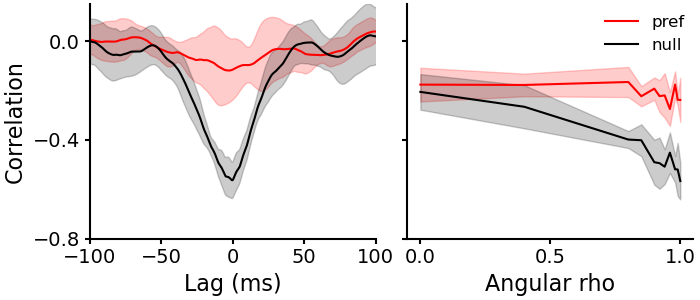

In [30]:
pn_xcorr_and_rho_vs_corr_fig, pn_xcorr_and_rho_vs_corr_ax = plt.subplots(
    1, 2, 
    sharey=True, 
    # gridspec_kw={"width_ratios": [0.6, 0.4]},
    gridspec_kw={"width_ratios": [0.5, 0.5]},
    figsize=(7, 3),
)

plot_pn_residual_corr(pn_xcorr_and_rho_vs_corr_ax[0], incl_lbl=False)
plot_pn_rho_vs_corr(pn_xcorr_and_rho_vs_corr_ax[1])

min_y = -0.8
pn_xcorr_and_rho_vs_corr_ax[0].set_xlim(-100, 100)
pn_xcorr_and_rho_vs_corr_ax[0].set_xticks([-100, -50, 0, 50, 100])
pn_xcorr_and_rho_vs_corr_ax[0].set_ylim(min_y, 0.15)
pn_xcorr_and_rho_vs_corr_ax[0].set_yticks([min_y, min_y / 2, 0.])
pn_xcorr_and_rho_vs_corr_ax[0].set_xlabel("Lag (ms)", fontsize=16)
pn_xcorr_and_rho_vs_corr_ax[0].set_ylabel("Correlation", fontsize=16)
pn_xcorr_and_rho_vs_corr_ax[1].set_xticks([0, 0.5, 1])
pn_xcorr_and_rho_vs_corr_ax[1].set_xlabel("Angular rho", fontsize=16)
pn_xcorr_and_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(pn_xcorr_and_rho_vs_corr_ax, ticksize=14, spine_width=1.5)
pn_xcorr_and_rho_vs_corr_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    name = os.path.join(fig_path, "pref_null_lag_and_rho_vs_residual_xcorr_%s%s%s" % (exp, shuffle_lbl, ext))
    pn_xcorr_and_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

In [23]:
close_button()